***
<p style="text-align:left;">Reinforcement Learning
<span style="float:right;">Monday, 25. May 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Monday, 01. June 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #6</b></p>

---

# 2. Dyna-Q

In this exercise you will implement **Dyna-Q**, which is a model-based Q-planning algorithm (planning with action values).

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from simplemaze import simple_maze_env
from collections import defaultdict
from time import sleep

## Simple Maze Environment

We will apply Dyna-Q to a **simple maze** environment, which is implemented in ```simplemaze.py```.  
The environment requires `gym-minigrid` (https://github.com/maximecb/gym-minigrid) to work.
You can install it using pip:  
```
pip install gym-minigrid
```

Run the following code, so the visualization of the environment works inside the notebook:

In [4]:
%matplotlib notebook
warnings.filterwarnings(action='ignore')
plt.ioff()

Let's construct the environment and take look at it:

<IPython.core.display.Javascript object>


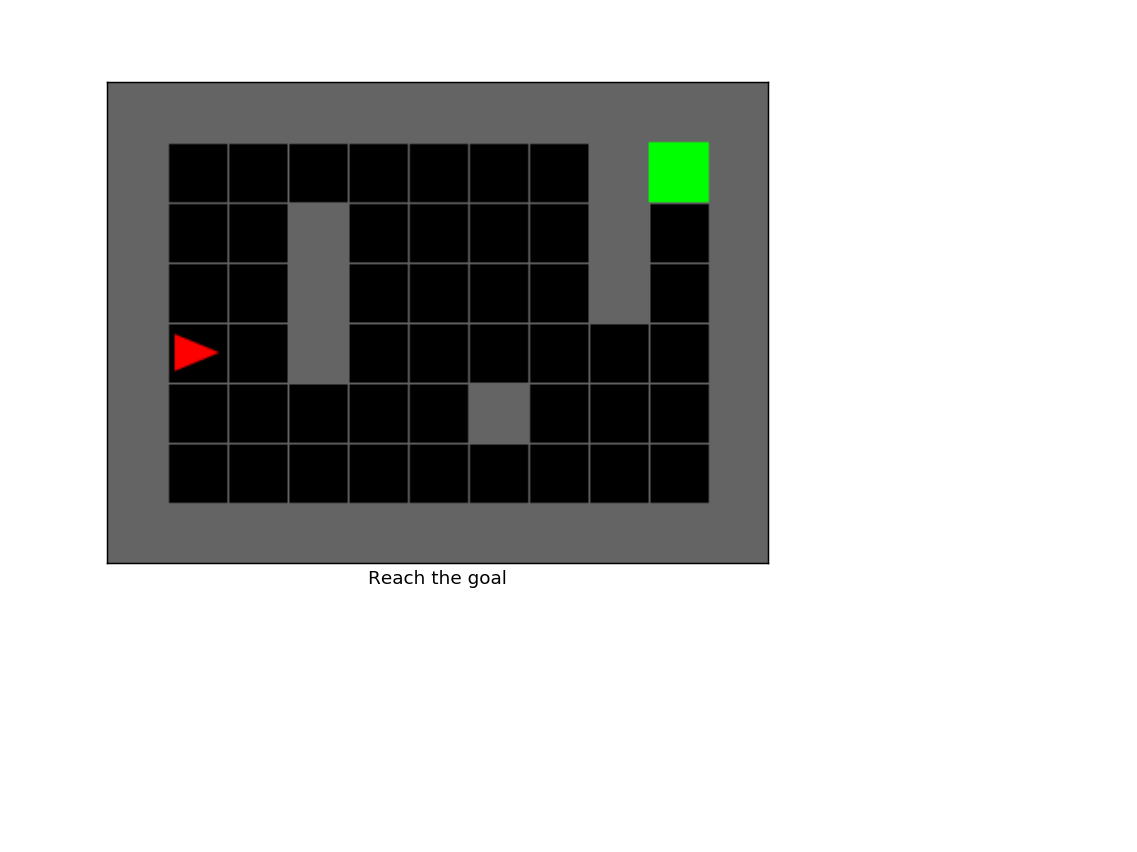

In [5]:
env = simple_maze_env()
env.reset()
env.render(highlight=False);

The observations are the location of the agent and its direction:

In [6]:
env.observation_space

Tuple(MultiDiscrete([11  8]), Discrete(4))

There are three discrete actions to move inside the grid:

In [7]:
print(env.action_space, '\n')
for i in range(env.action_space.n):
    print(i, env.actions(i))

Discrete(3) 

0 Actions.left
1 Actions.right
2 Actions.forward


The objective is to...

In [8]:
env.mission

'Reach the goal'

If the player reaches a goal, it gets a reward up to one (discounted by number of steps taken) and the episode ends.
Otherwise, the reward is zero.

The episode ends likewise with reward zero if you exceed 1000 steps.

In [9]:
print("The reward is in", env.reward_range)
print("Don't exceed", env.max_steps, "steps!")

The reward is in (0, 1)
Don't exceed 1000 steps!


For each environment, rendering will only work in a single notebook cell.  
If you want to use graphical output in multiple cells, create a new environment.

Try out this animated example with random actions:

<IPython.core.display.Javascript object>


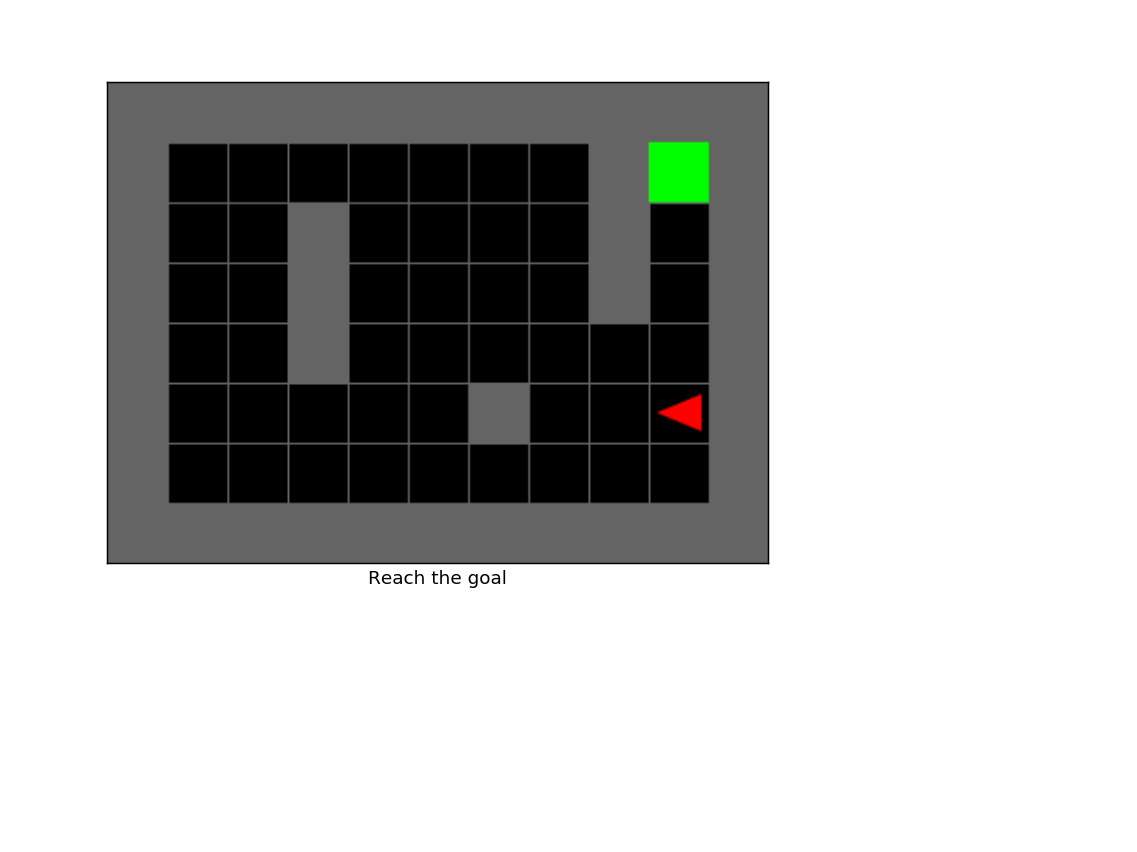

In [10]:
env = simple_maze_env()

obs = env.reset()
for _ in range(50):
    act = env.action_space.sample()
    obs, reward, done, info = env.step(act)
    env.render(highlight=False);
    sleep(40e-3)

## Implement Dyna-Q
Implement the Tabular Dyna-Q algorithm described in Chapter 8.2 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto, p. 164.

![](http://incompleteideas.net/book/first/ebook/pseudotmp18.png)

Dyna-Q uses the same epsilon-greedy action selection and Q update formula that you already know. Implement those first:

In [11]:
def argmax_random(x):
    return np.random.choice(np.flatnonzero(x == x.max()))

def epsilon_greedy_action(env, Q, epsilon, state):
    if np.random.binomial(1, epsilon) == 1:
        action = np.random.randint(0, 2)
    else:
        action = argmax_random(Q[state])
    return action

def update_Q(Q, old_state, new_state, action, reward, alpha, gamma=0.95):
    Q[old_state][action] = (
        Q[old_state][action] 
        + alpha 
        * (reward 
           + gamma
           * np.amax([Q[new_state][action_] for action_ in range(env.action_space.n)]) 
           - Q[old_state][action])
    )
    return Q

Now implement the main part of the algorithm:

In [12]:
def train_dyna_Q(env, num_episodes, n=5, alpha=0.1, epsilon=0.1, silent=False):
    """Estimate optimal action-value function using the Dyna-Q algorithm.
    
    Args:
        env: The environment to train on.
        num_episodes: Number of episodes to run.
        n: The number of planning steps in Dyna-Q.
        alpha: Step size for the action-value update.
        epsilon: Parameter for the epsilon greedy action selection.
    
    Returns:
        Q: The finished Q-table.
        num_steps: Array containing number of steps per episode.
    """
    
    # initialize Dyna-Q variables
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    model = {}
    
    num_steps = []
    
    for episode in range(1, num_episodes + 1):
        if not silent:
            print("\rEpisode {}/{}".format(episode, num_episodes), flush=True, end='')
        
        state = env.reset()
        done = False
        while not done:
            # step (a) to (f)
            action = int(epsilon_greedy_action(env, Q, epsilon, state))
            state_, reward, done, _ = env.step(action)
            Q = update_Q(Q, state, state_, action, reward, alpha)
            model[state, action] = state_, reward
            prev_states, _ = zip(*model.keys())
            for i in range(n):
                idx = np.random.randint(len(prev_states))
                rand_state = prev_states[idx]
                prev_a_in_s = [a for s, a in model.keys() if s == rand_state]
                rand_action = np.random.choice(prev_a_in_s)
                s_, r = model[rand_state, rand_action]
                Q = update_Q(Q, rand_state, s_, rand_action, r, alpha)
            state = state_
        
        num_steps.append(env.step_count)
    
    return Q, np.array(num_steps)

Let's test your implementation:

In [13]:
env = simple_maze_env()
Q, _ = train_dyna_Q(env, 50)

Episode 50/50

Now your agent should find the goal easily:

<IPython.core.display.Javascript object>


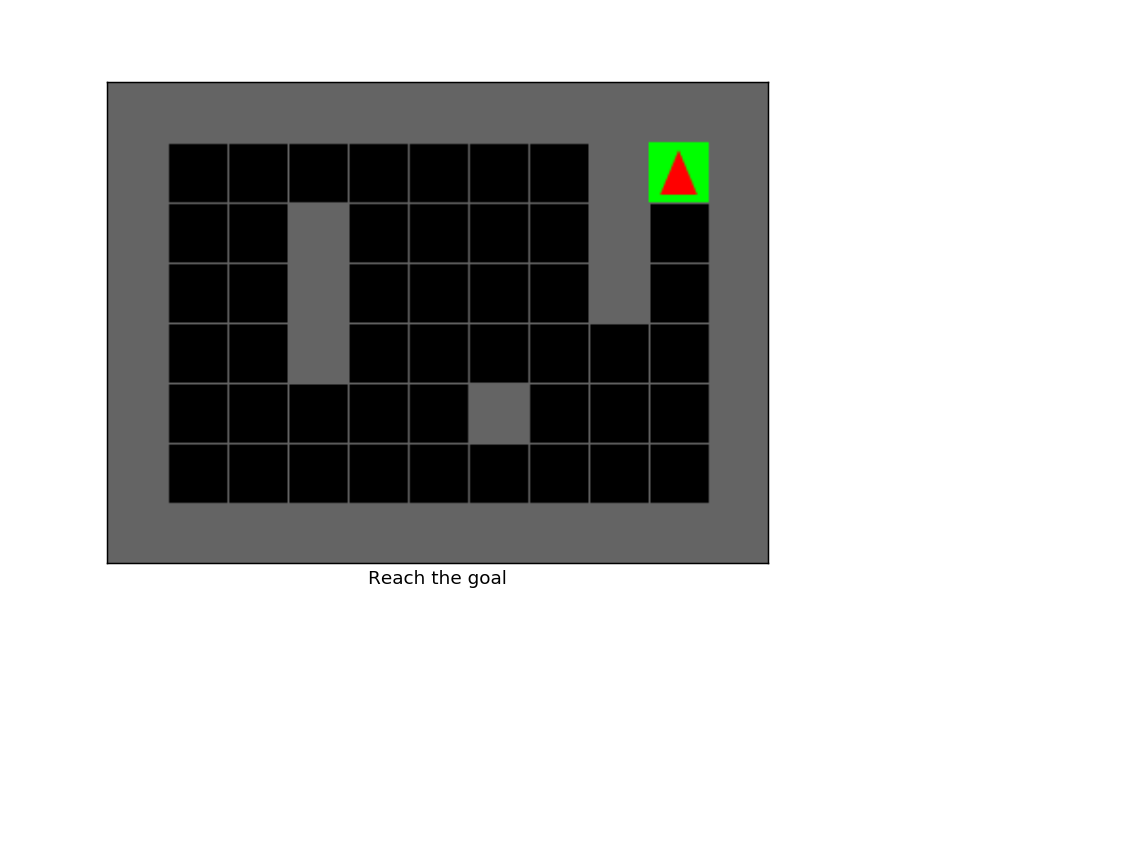

In [16]:
env = simple_maze_env()

state = env.reset()
for _ in range(100):
    action = epsilon_greedy_action(env, Q, 0, state)
    state, reward, done, info = env.step(action)
    env.render(highlight=False)
    if done:
        break
    sleep(40e-3)

## Key parameters in Dyna-Q

Now you will explore the role of the key paramters $n$ and $\alpha$. 

#### Exploring $n$
In particular, recreate Figure 8.2 from Sutton and Barto, p. 165, by plotting the learning curves averaged over 10 runs for $n \in \{0,5,50\}$:

In [31]:
%%time
# measures the execution time
from tqdm import tqdm
# first collect the data for plotting
runs = 10

ns = [0, 5, 50]

num_steps_for_n = []
for n in ns:
    num_steps_array = []
    for run in range(runs):
        env = simple_maze_env()
        _, num_steps = train_dyna_Q(env, 50, n=n)
        num_steps_array.append(num_steps)
    num_steps_for_n.append(np.mean(num_steps_array, axis=0))

Episode 50/50Wall time: 4min 53s


<IPython.core.display.Javascript object>


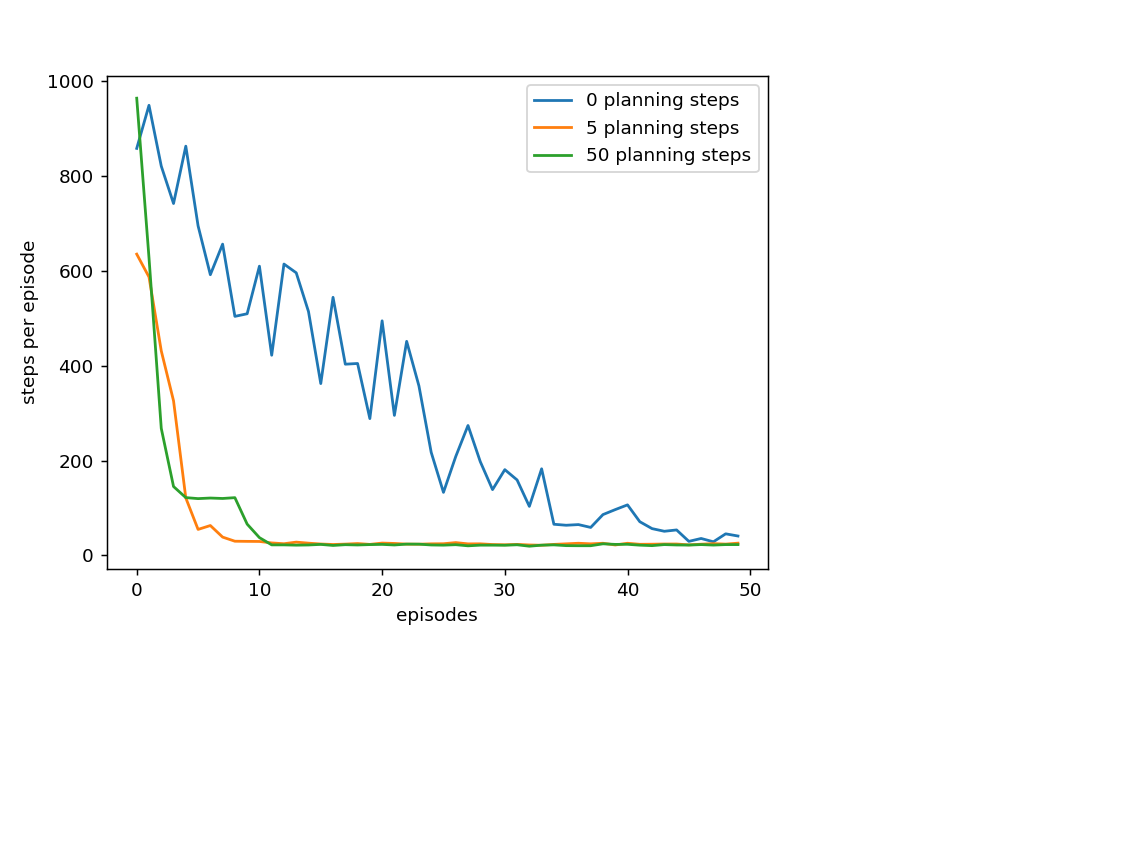

In [32]:
# then plot the data
plt.figure()
for i in range(len(ns)):
    plt.plot(num_steps_for_n[i], label='%d planning steps' % (ns[i]))
plt.xlabel('episodes')
plt.ylabel('steps per episode')
plt.legend()

#### Exploring $\alpha$
Now also plot the learning curves averaged over 10 runs for $\alpha \in \{0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0\}$:

In [33]:
%%time
# measures the execution time
# first collect the data for plotting
runs = 10

alphas = [0.03125,0.0625,0.125,0.25,0.5,1.0]

num_steps_for_alpha = []
for alpha in alphas:
    num_steps_array = []
    for run in range(runs):
        env = simple_maze_env()
        _, num_steps = train_dyna_Q(env, 50, alpha=alpha)
        num_steps_array.append(num_steps)
    num_steps_for_alpha.append(np.mean(num_steps_array, axis=0))

Episode 50/50Wall time: 4min 31s


<IPython.core.display.Javascript object>


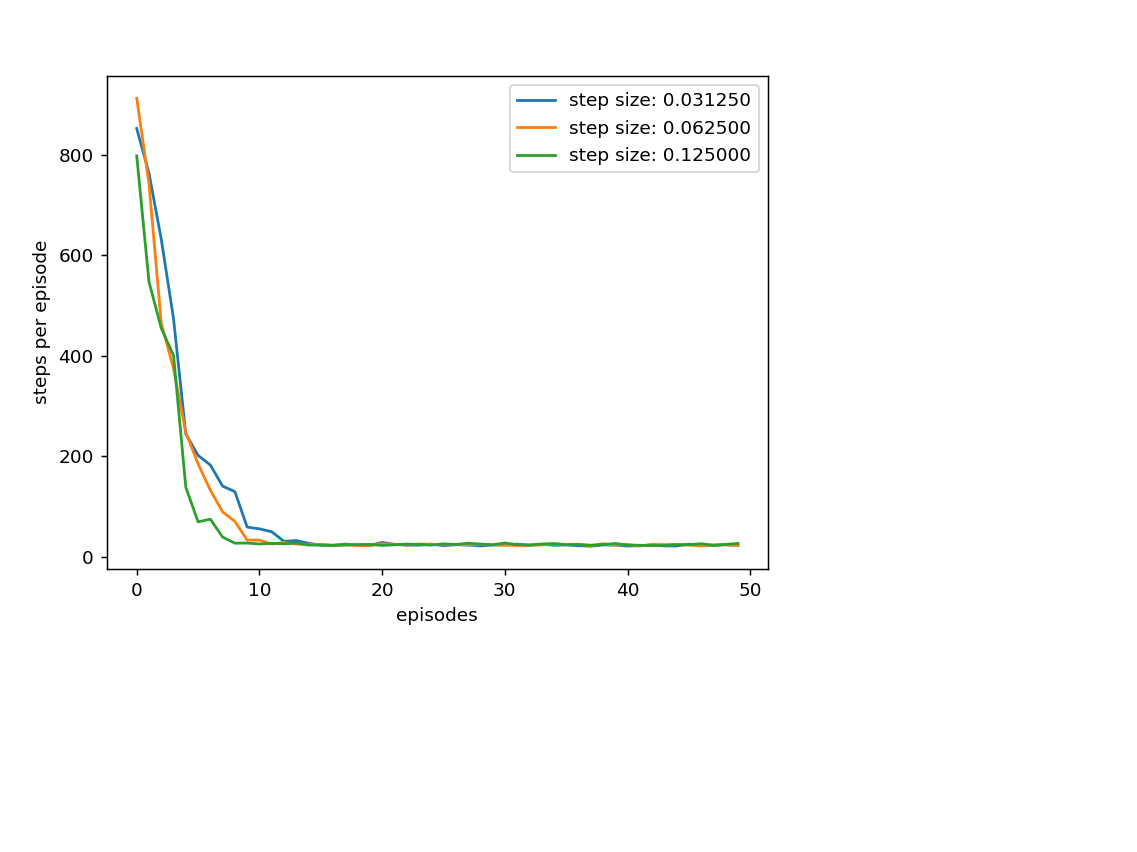

In [37]:
# then plot the data
plt.figure()
for i in range(len(ns)):
    plt.plot(num_steps_for_alpha[i], label='step size: %f' % (alphas[i]))
plt.xlabel('episodes')
plt.ylabel('steps per episode')
plt.legend()